# Closest pixel

In [1]:
import cv2
import numpy as np
import numpy as np
import rasterio
from scipy.ndimage import distance_transform_edt

In [14]:
year = 5
data_type = "aggregated"
path = f"../data/processed/{30}m/{data_type}/"  + f"{data_type}_{year}.tif"
with rasterio.open(path) as src:
    fill_value = 255 if data_type == "landuse" else 0
    # window = rasterio.windows.Window(50000, 50000, 20000, 20000)
    # data = src.read(window=window)
    data = src.read()
    data = data.squeeze()
    data = data.astype(bool) if data_type == "aggregated" else data.astype(np.uint8)
    data = data == False
    data = data.astype(np.uint8)


In [28]:
dist_arr = cv2.distanceTransform(data[::55,::55], distanceType=cv2.DIST_L2, maskSize=3) # cv2.DIST_MASK_PRECISE


In [16]:
dist_arr.dtype

dtype('float32')

In [19]:
dist_arr.shape

(95538, 101856)

In [8]:
out_path = "../data/processed/30m/distance/distance_5.tif"
out_meta = src.meta.copy()
out_meta.update({"dtype": "float32", "compress": "DEFLATE"})
with rasterio.open(out_path, "w", **out_meta) as dest:
    dest.write(np.expand_dims(dist_arr, axis=0))

In [28]:
np.max(dist_arr)

1900.0

In [9]:
out_path = "../data/processed/30m/distance/distance_5.tif"
with rasterio.open(out_path) as src:
    fill_value = 255 if data_type == "landuse" else 0
    dist_arr = src.read(window=window)
    dist_arr = dist_arr.squeeze().astype(np.float16)
    # data = data.astype(bool) if data_type == "aggregated" else data.astype(np.uint8)

In [10]:
dist_arr.dtype

dtype('float16')

In [21]:
dist_arr[50000:51000,50000:51000]

array([[30265.105, 30264.105, 30263.105, ..., 29268.11 , 29267.11 ,
        29266.11 ],
       [30265.104, 30264.104, 30263.104, ..., 29268.107, 29267.107,
        29266.107],
       [30265.102, 30264.1  , 30263.1  , ..., 29268.104, 29267.104,
        29266.104],
       ...,
       [30270.305, 30269.305, 30268.305, ..., 29273.35 , 29272.35 ,
        29271.35 ],
       [30270.295, 30269.295, 30268.295, ..., 29273.34 , 29272.34 ,
        29271.34 ],
       [30270.285, 30269.285, 30268.285, ..., 29273.33 , 29272.328,
        29271.33 ]], dtype=float32)

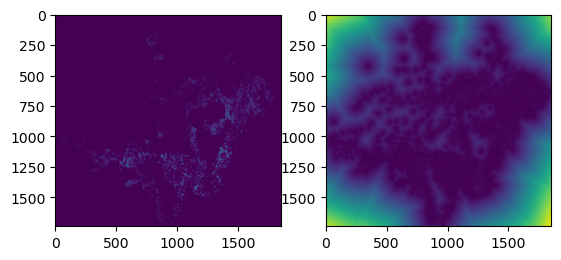

In [29]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(data[::55,::55] == False)
plt.subplot(1, 2, 2)
plt.imshow(dist_arr)
plt.show()


# slope data

In [103]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
from rasterio.merge import merge
import numpy as np
import matplotlib.pyplot as plt

In [134]:
def load_window(year, window_size=5100, offset=[0,0], data_type="landuse", dataset="train"):
    suffix = "_test" if dataset == "test" else ""
    path = f"../data/processed/{30}m/{data_type}/"  + f"{data_type}_{year}{suffix}.tif"
    # Open the mosaic file
    with rasterio.open(path) as src:
        fill_value = 255 if data_type == "landuse" else 255
        window = rasterio.windows.Window(offset[0], offset[1], window_size, window_size)
        data = src.read(window=window, fill_value=fill_value, boundless=True)
        data = data.squeeze()
        data = data.astype(bool) if data_type == "aggregated" else data.astype(np.uint8)
    return data, window, src

In [135]:
delta = 55
window_size = delta * 500

window_x = 0
window_y = 3
offset = [window_x*window_size, window_y*window_size]
aggregated, window, aggregated_src = load_window(1, window_size=window_size, offset=offset, data_type="aggregated")

In [124]:
window_bounds = rasterio.windows.bounds(window, aggregated_src.transform)

In [125]:
print(rasterio.warp.transform_bounds(aggregated_src.crs, "EPSG:4326", *aggregated_src.bounds)) # x_min, y_min, x_max, y_max -> S20W080, N10W040

(-73.98327050645872, -16.66198330503171, -43.39908695553902, 5.2696971139907)


In [126]:
path_fabdem = "../data/raw/fabdem/"
path_fabdem_tiles = []
# get path to all tif files in all folders 
for root, dirs, files in os.walk(path_fabdem):
    for file in files:
        if file.endswith(".tif"):
             path_fabdem_tiles.append(os.path.join(root, file))

In [127]:
# Identify the tiles that intersect with the spatial extent of the window
tiles_to_load = []
for path_fabdem in path_fabdem_tiles:
    src = rasterio.open(path_fabdem)
    
    # calculate transformed bounds
    dst_crs = "EPSG:6933"
    tile_bounds = rasterio.warp.transform_bounds(src.crs, dst_crs, *src.bounds)

    # check if tile_bounds has any overlap with window_bounds
    if not rasterio.coords.disjoint_bounds(tile_bounds, window_bounds):
        tiles_to_load.append(src)
    else:
        src.close()
            
mosaic, out_trans = merge(tiles_to_load)

In [128]:
out_meta = src.meta.copy()
    
# Get bounds of the merged mosaic
out_height, out_width = mosaic.shape[1], mosaic.shape[2]
out_ulx, out_uly = out_trans * (0, 0)
out_lrx, out_lry = out_trans * (out_width, out_height)
bounds = (out_ulx, out_lry, out_lrx, out_uly)

out_meta.update({"driver": "GTiff", 
                    "height": mosaic.shape[1],
                    "width": mosaic.shape[2],
                    "transform": out_trans
                    })

# reproject into crs "EPSG:6933"
dst_crs = "EPSG:6933"
transform, width, height = calculate_default_transform(
            src.crs, dst_crs, out_meta['width'], out_meta['height'], *bounds, resolution=aggregated_src.meta['transform'][0])

destination = np.zeros((height,width), np.float32)
array_out, transform_out = reproject(
    source=mosaic[0],
    destination=destination,
    src_transform=out_trans,
    src_crs=src.crs,
    dst_transform=transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest)


In [129]:
out_ulx, out_uly = transform * (0, 0)
out_lrx, out_lry = transform * (width, height)
bounds_dest = (out_ulx, out_lry, out_lrx, out_uly)
print(bounds_dest)
print(window_bounds)
print(transform)
print(aggregated_src.transform)

(-7139998.139438598, -2501281.750682071, -6271596.686864099, -1644613.8868275518)
(-7138370.571964064, -2515550.181103332, -6341645.411965441, -1718825.0211047092)
| 28.97, 0.00,-7139998.14|
| 0.00,-28.97,-1644613.89|
| 0.00, 0.00, 1.00|
| 28.97, 0.00,-7138370.57|
| 0.00,-28.97, 671350.46|
| 0.00, 0.00, 1.00|


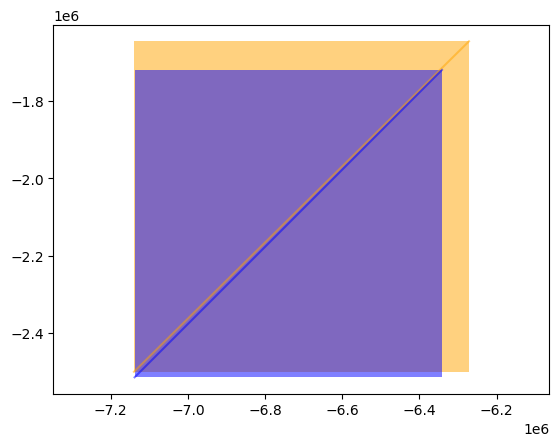

In [130]:
# plot bounds_dest and window_bounds as two rectangles
from matplotlib.patches import Rectangle
fig,ax = plt.subplots(1)
ax.plot([bounds_dest[0], bounds_dest[2]],[bounds_dest[1], bounds_dest[3]], alpha=0.5, color="orange")
ax.plot([window_bounds[0], window_bounds[2]],[window_bounds[1], window_bounds[3]], alpha=0.5, color="blue")
ax.add_patch(Rectangle((bounds_dest[0], bounds_dest[1]), bounds_dest[2]-bounds_dest[0], bounds_dest[3]-bounds_dest[1], alpha=0.5, facecolor="orange"))
ax.add_patch(Rectangle((window_bounds[0], window_bounds[1]), window_bounds[2]-window_bounds[0], window_bounds[3]-window_bounds[1], alpha=0.5, facecolor="blue"))
ax.axis("equal")
plt.show()

In [137]:
# get window from window_bounds and transform
window_dest = rasterio.windows.from_bounds(*window_bounds, transform=transform)
# convert window_dest to int offsets, note that it is not subscriptable
window_dest = [int(round(window_dest.col_off)), int(round(window_dest.row_off)), int(round(window_dest.width)), int(round(window_dest.height))]
destination_window = destination[window_dest[1]:window_dest[1]+window_dest[3], window_dest[0]:window_dest[0]+window_dest[2]]
# pad destination_window to match aggregated
destination_window = np.pad(destination_window, ((0, aggregated.shape[0]-destination_window.shape[0]), (0, aggregated.shape[1]-destination_window.shape[1])), mode="constant", constant_values=0)


In [138]:
print(destination.shape)
print(destination_window.shape)
print(aggregated.shape)

(29569, 29974)
(27500, 27500)
(27500, 27500)


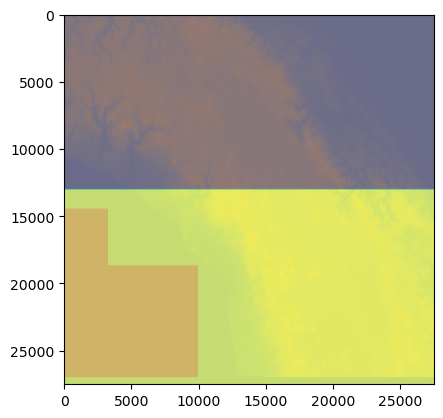

In [139]:
plt.imshow(destination_window, alpha=0.5)
plt.imshow(aggregated, alpha=0.5)
plt.show()